# Plot screening data from pickle file

Example script of how to plot virtual screening data (stored in a pickle file). 

I have two datasets of ligands called fuz='custom designed ligands' and crystal='original crystal ligands'.
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20230410164437/AUC-ROC-Curve.webp" align="right" width="300" height="300" />

The size of the datasets is variable. Meaning that for one protein target there could be 10 crystal ligands 
and 12 fuz ligands calculated, and for the next protein there could be 150 crystal ligands and 100 fuz ligands 
calculated.
For each ligand fuz/crystal a virtual screening was performed against a ligand dataset, and an AUC was calculated. The AUC, the Area Under the Curve can be represented as a single value, which indicates the success rate of the screening.

These AUC scores were plotted comparing fuz ligands against crystal ligands.

Because of the variable number of datapoints I choose to plot the range of scores for each protein. The crystal ligand data is represented as a range. The fuz ligand data is represented as a violin plot. 

* By: Susanne Hermans, 2024

<em>Source: https://www.geeksforgeeks.org/auc-roc-curve/</em>


### Load AUC databases from file

In [20]:
import pandas as pd
import numpy as np


file_df_cryst="AUCcryst.pkl"
file_df_fuz="AUCfuz.pkl"
AUCdf_cryst=pd.read_pickle(file_df_cryst)
AUCdf_fuz=pd.read_pickle(file_df_fuz)

### Additional filtering of data with too little crystal ligands

In [21]:
AUCdf_cryst=AUCdf_cryst.drop(AUCdf_cryst[AUCdf_cryst.system.isin(['1mzc', '1xoz', '1r9o', '1m2z', '1n46'])].index)
AUCdf_cryst=AUCdf_cryst.sort_values("system", ascending=True)

AUCdf_fuz=AUCdf_fuz.drop(AUCdf_fuz[AUCdf_fuz.system.isin(['1mzc', '1xoz', '1r9o', '1m2z', '1n46'])].index)
AUCdf_fuz=AUCdf_fuz.sort_values("system", ascending=True)

### Select which scoring function to use:

Choose from:
* tanimoto
* fittversky
* reftversky

In [22]:
score_function="fittversky"

### Convert crystal ligand data into dictionary

In [23]:
import math

def calculate_auc_stats(AUCdf_cryst, score_type):
    # Create column name based on the score type
    score_column = f'AUC_{score_type}'
    
    # Calculate mean, std, lower and upper bounds
    average_AUC_cryst = AUCdf_cryst[[score_column, 'system']].groupby('system').mean()
    average_AUC_cryst_std = AUCdf_cryst[[score_column, 'system']].groupby('system').std()
    average_AUC_cryst_std_lower = average_AUC_cryst - average_AUC_cryst_std
    average_AUC_cryst_std_upper = average_AUC_cryst + average_AUC_cryst_std
    
    return(average_AUC_cryst, average_AUC_cryst_std, average_AUC_cryst_std_lower, average_AUC_cryst_std_upper)

# Example usage:
# Replace 'fittversky' with 'tanimoto' or 'reftversky' as needed
average_AUC_cryst, average_AUC_cryst_std, average_AUC_cryst_std_lower, average_AUC_cryst_std_upper = (
                                                            calculate_auc_stats(AUCdf_cryst, score_function))

average_AUC_cryst_dict={}
for sys in average_AUC_cryst.index.to_list():
    mean=average_AUC_cryst.loc[sys][0]
    lower=average_AUC_cryst_std_lower.loc[sys][0]
    if math.isnan(lower): lower=mean
    upper=average_AUC_cryst_std_upper.loc[sys][0]
    if math.isnan(upper): upper=mean
    average_AUC_cryst_dict[sys]=[mean, lower, upper] 

### Convert fuz ligand data into dictionary

In [24]:
score="AUC_"+score_function

AUC_fuz_dict={}

for i in AUCdf_fuz.index.to_list():
    sys=AUCdf_fuz.loc[i].system
    #skip systems that is are not in the crystal dataset.
    if sys not in average_AUC_cryst_dict.keys():
        print("skipping:", sys)
        continue
    if sys in AUC_fuz_dict.keys():
        AUC_fuz_dict[sys].append(AUCdf_fuz.loc[i][score])
    else:
        AUC_fuz_dict[sys]=[AUCdf_fuz.loc[i][score]]

skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1l2s
skipping: 1n1m
skipping: 1n1m


### Plot the data!

* The crystal ligand data is represented as a black line for the mean values and a grey range for the  first standard deviation. 
* The fuz ligand data is represented as a red violin plot. 

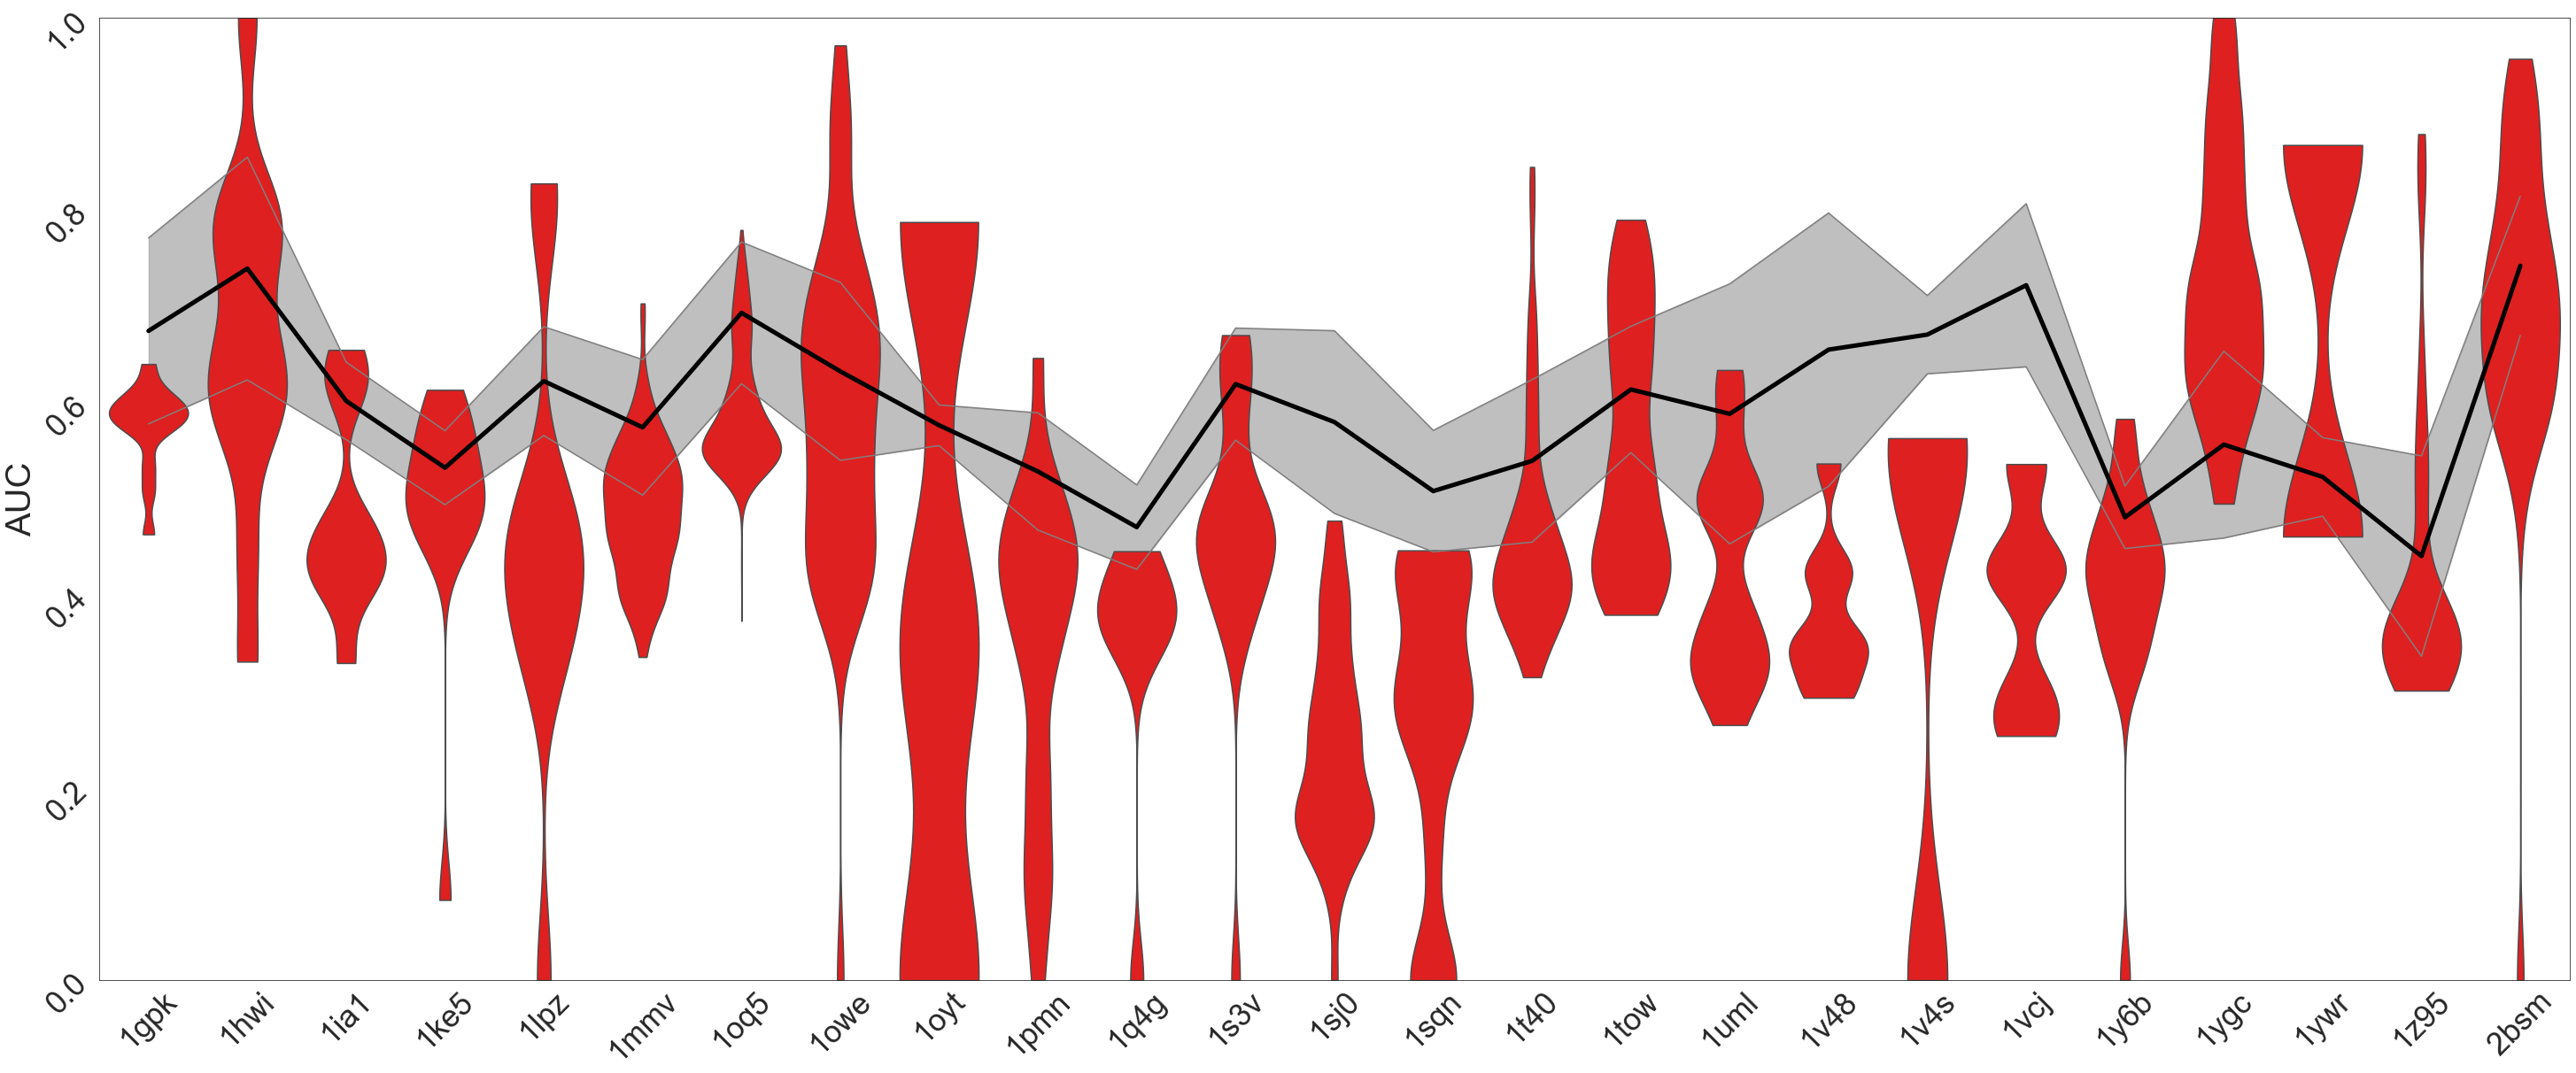

In [25]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# Assuming 'weights_db' is your DataFrame
sns.set_style('white')
palette = 'Set2'

# Create a white background for the plot
fig, ax = plt.subplots(figsize=(50, 20))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

keys_list=[k for k in list(AUC_fuz_dict.keys()) if k in average_AUC_cryst_dict.keys()]
#print(keys_list)
keys = keys_list
# get values in the same order as keys, and parse percentage values
mean_values = [average_AUC_cryst_dict[k][0] for k in keys]
lower_values= [average_AUC_cryst_dict[k][1] for k in keys]
upper_values= [average_AUC_cryst_dict[k][2] for k in keys]
#fuz_scores= [np.array(AUC_fuz_dict[k]) for k in keys]

a = sns.lineplot(x=keys, y=mean_values, color='black', linewidth=5) 
b = sns.lineplot(x=keys, y=lower_values, color='gray')
c = sns.lineplot(x=keys, y=upper_values, color='gray')

# Find the correct lines for fill_between
lines = ax.lines
line_main = lines[0]
line_lower = lines[1]
line_upper = lines[2]

# Get x-data from the main line
x_data = line_main.get_xdata()

# Interpolate y-values for the upper and lower lines
y_lower_interp = np.interp(x_data, line_lower.get_xdata(), line_lower.get_ydata())
y_upper_interp = np.interp(x_data, line_upper.get_xdata(), line_upper.get_ydata())

# Fill between the lines
ax.fill_between(x_data, y_lower_interp, y_upper_interp, color='gray', alpha=.5)

# Violin plot
AUCdf_fuz=AUCdf_fuz.loc[AUCdf_fuz["system"].isin(keys)]
sns.violinplot(x="system", y="AUC_fittversky", data=AUCdf_fuz, color='red', alpha=0.2, dodge=False, scale="width", inner=None, cut=0, bw=0.3, ax=ax)

# Box plot
# sns.boxplot(x="system", y="AUC_tanimoto", data=AUCdf_fuz, saturation=1, showfliers=False,
#             width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)

# Preserve the axis limits
xlim = ax.get_xlim()
ylim = (0.0, 1.0)

# Set the axis limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Remove the x-axis label
ax.set_xlabel("")

# Set the y-axis label font size
ax.set_ylabel("AUC", fontsize=40)

# Set the tick label font size
ax.tick_params(axis='both', which='major', labelsize=35, rotation=45)

# Remove the legend
# ax.legend_.remove()

# Save the plot to a file (e.g., in PNG format)
plt.savefig('violinplot_fittversky.png', bbox_inches='tight')

# Show the plot
plt.show()